# Regulome Explorer  Spearman Correlation for numerical data
Check out more notebooks at our ['Regulome Explorer Repository'](https://github.com/isb-cgc/Community-Notebooks/tree/master/RegulomeExplorer)!


```
Title:   Regulome Explorer Spearman correlation
Author:  Boris Aguilar
Created: 01-13-2020
Purpose: Demonstrate how to compute Spearman correlation coefficients from BigQuery tables
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/RegulomeExplorer/RE-SpearmanCorrelation.ipynb

```
***
In this notebook, we describe the computation of the Spearman correlation coefficient typically used to estimate the significance of associations between two numerical data types; in this case the numerical data are the gene expression of two user defined genes. To describe the implementation, we used the gene expression table of the [pancancer-atlas dataset](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/PanCancer-Atlas-Mirror.html). More details of the Spearman correlation can be found the following link: https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient

The Spearman correlation is also implemented in the ['Regulome Explorer notebook'](https://github.com/isb-cgc/Community-Notebooks/blob/master/RegulomeExplorer/RegulomeExplorer-notebook.ipynb) which computes statistical associations between other numerical data types available in the pancancer-atlas dataset, such as copy number variation, protein expression, clinical features, etc.

## Authenticate with Google  (IMPORTANT)
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

#### Import Python libraries

In [1]:
%matplotlib inline
from google.cloud import bigquery
import pandas as pd
from scipy import stats
import seaborn as sns
import re_module.bq_functions as regulome

## User defined Parameters
The parameters for this implementation are the cancer type and the name of the genes for which gene expression data will be obtained.   

In [2]:
cancer_type = 'UCEC'
gene_expre1 = 'IGJ'
gene_expre2 = 'ADAM6'


bqclient = bigquery.Client()

## Data from BigQuery tables

**Gene expression data from gene1:** The following query string retrieves the gene expression of the user specified gene1 ('gene_expre1') from the 'Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered' table available in pancancer-atlas dataset. The gene expression of a participant is computed as the average gene expression of the tumor samples of the participant.

In [3]:
bigquery_table1 = 'pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered'
query_table1 = """table1 AS (
SELECT Symbol, data, ParticipantBarcode
FROM ( 
   SELECT 
         Symbol AS symbol, AVG( LOG10( normalized_count + 1 )) AS data, ParticipantBarcode
   FROM  `{0}` 
   WHERE Study = '{1}' AND Symbol ='{2}' AND normalized_count IS NOT NULL         
   GROUP BY 
         ParticipantBarcode, symbol
   )
)
""".format( bigquery_table1, cancer_type, gene_expre1 )

**Gene expression data from gene2:** The following string query will retrieve the gene expression of the user specified gene2 ('gene_expre2'). This is very similar to the query used for gene1.

In [4]:
bigquery_table2 = 'pancancer-atlas.Filtered.EBpp_AdjustPANCAN_IlluminaHiSeq_RNASeqV2_genExp_filtered'
query_table2 = """table2 AS (
SELECT Symbol, data, ParticipantBarcode
FROM ( 
   SELECT 
         Symbol AS symbol, AVG( LOG10( normalized_count + 1 )) AS data, ParticipantBarcode
   FROM  `{0}` 
   WHERE Study = '{1}' AND Symbol ='{2}' AND normalized_count IS NOT NULL         
   GROUP BY 
         ParticipantBarcode, symbol
   )
)
""".format( bigquery_table2, cancer_type, gene_expre2 )

At this point we can take a look at the combined data (Gene expression of the two genes) by using a simple INNER  JOIN command. 

In [5]:
sql_data = 'WITH\n'+ query_table1 +','+ query_table2  

sql = (sql_data + 
"""
SELECT 
    n1.data as data1,  
    n2.data as data2,  
    n1.ParticipantBarcode
FROM
    table1 n1  
INNER JOIN  table2   n2 
ON  n1.ParticipantBarcode = n2.ParticipantBarcode
""")

df_data = regulome.runQuery ( bqclient, sql, [] , dryRun=False )
df_data[1:10]


 in runQuery ... 
    this query processed 7757877633 bytes 
    Approx. elpased time : 2798 miliseconds 


,data1,data2,ParticipantBarcode
1,2.819599,3.831652,TCGA-AX-A2HD
2,2.180091,3.760516,TCGA-EO-A1Y7
3,3.027851,4.325743,TCGA-DF-A2KR
4,3.159486,4.401590,TCGA-QS-A5YQ
5,2.006008,3.369119,TCGA-QF-A5YT
6,3.278023,4.434266,TCGA-AX-A1CF
7,3.148507,4.542022,TCGA-A5-A2K4
8,2.778011,3.745502,TCGA-BG-A0W2
9,3.720214,4.769811,TCGA-AJ-A2QK


To visualize the gene expression data of the two user defined genes, we can use a scatter plot:

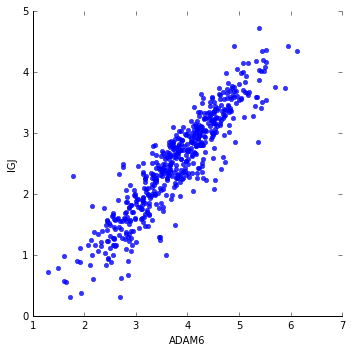

In [6]:
df_data.rename(columns={ "data1": gene_expre1, "data2": gene_expre2 }, inplace=True)
sns.lmplot( x=gene_expre2, y=gene_expre1, data=df_data, fit_reg=False )

##  BigQuery to Compute statistical association 

The Spearman correlation coefficient is defined as the Pearson correlation coefficient computed using ranked variables. BigQuery supports several statistical aggregate functions including a function to compute ['Pearson correlation'](https://cloud.google.com/bigquery/docs/reference/standard-sql/statistical_aggregate_functions#corr). Thus, the computation of the Spearman correlation is performed by the following steps:

1. Combine the two tables containing the gene expression data
2. Compute ranked gene expression data
3. Use the BigQuery function CORR on the ranked data

The following query performs steps 1 and 2. The two tables are combined by using an INNER JOIN command. There are several methods to rank numerical data, depending on what rank value is assigned to values that are equal, ['see this link'](https://www.geeksforgeeks.org/python-pandas-dataframe-rank/). Spearman correlation typically requires assigning the average of ranks to the similar values. Unfortunately, this method is not available as a simple BigQuery command. Nevertheles, the following query combines the RANK and COUNT BigQuery commands to generate the average ranked data.  

In [7]:
summ_table = """summ_table AS (
SELECT
    (RANK() OVER ( ORDER BY n1.data ASC)) + (COUNT(*) OVER ( PARTITION BY CAST(n1.data as STRING)) - 1)/2.0 as rnkdata1,
    (RANK() OVER ( ORDER BY n2.data ASC)) + (COUNT(*) OVER ( PARTITION BY CAST(n2.data as STRING)) - 1)/2.0 as rnkdata2,
    n1.ParticipantBarcode
FROM
    table1 n1  
INNER JOIN  table2   n2 
ON  n1.ParticipantBarcode = n2.ParticipantBarcode
)
"""

Once the ranked data is computed, we use the following query that uses the CORR command to compute the Spearman correlation coefficient.

In [8]:
query_corr = """
SELECT 
   COUNT(*) as npatients,
   CORR( rnkdata1 , rnkdata2 ) as correlation
FROM summ_table
"""
sql = ( sql_data  + ',\n' + summ_table + query_corr )

df_corr = regulome.runQuery ( bqclient, sql, [] , dryRun=False )
df_corr


 in runQuery ... 
    this query processed 7757877633 bytes 
    Approx. elpased time : 2627 miliseconds 


,npatients,correlation
0,540,0.918271


To test our implementation we can use the 'spearmanr' function available in python:

In [9]:
print(  stats.spearmanr(df_data[ gene_expre1 ],df_data[gene_expre2])  )

SpearmanrResult(correlation=0.91827140086976378, pvalue=1.2724813661443188e-218)
